# Autoencoder network with MedNIST Dataset

This notebook illustrates the use of an autoencoder in MONAI for the purpose of image deblurring/denoising.

# Learning objectives
This will go through the steps of:
* Loading the data from a remote source
* Using a lambda to create a dictionary of images
* Using MONAI's in-built AutoEncoder

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/autoencoder_mednist.ipynb)

## Setup environment

In [1]:
# Importar la librería MONAI
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"

## Setup imports

In [2]:
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from skimage.util import random_noise

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import AutoEncoder
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    EnsureTypeD,
    Lambda,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2427
Numpy version: 1.21.2
Pytorch version: 1.9.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cbf90d0ddb27dc96a91385e4dd2f4eb239dea976
MONAI __file__: c:\Course\<username>\anaconda3\envs\pytorchenv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
scipy version: 1.7.1
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.1+cpu
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: 

In [3]:
# Copia en la carpeta split (imagesTr, imagesTs) los casos de training, validación y testing que se han dividido arriba

import os
import shutil

directory = 'C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/data'
directory_masks = 'C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks'

# Copia de archivos
for carpeta in os.listdir(directory):
    ruta_carpeta = os.path.join(directory, carpeta)
    if os.path.isdir(ruta_carpeta):  
        # Recorremos las subcarpetas dentro de cada carpeta principal
        for archivo in os.listdir(ruta_carpeta):
            if archivo.endswith('_gt.nii.gz'):
                ruta_archivo = os.path.join(ruta_carpeta, archivo)
                if os.path.isfile(ruta_archivo):
                    shutil.copy2(ruta_archivo, directory_masks)
                    print(f"Archivo copiado a {directory_masks}")
            

Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/databas

In [4]:
import os
import shutil

directory_training = 'C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/training'
directory_masks_training = 'C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training'
# Copia de archivos
for carpeta in os.listdir(directory_training):
    ruta_carpeta = os.path.join(directory_training, carpeta)
    if os.path.isdir(ruta_carpeta):  
        # Recorremos las subcarpetas dentro de cada carpeta principal
        for archivo in os.listdir(ruta_carpeta):
            if archivo.endswith('_gt.nii.gz'):
                ruta_archivo = os.path.join(ruta_carpeta, archivo)
                if os.path.isfile(ruta_archivo):
                    shutil.copy2(ruta_archivo, directory_masks_training)
                    print(f"Archivo copiado a {directory_masks_training}")

Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_training
Archivo copiado a C:/Users/L

In [5]:
directory_testing = 'C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/testing'
directory_masks_testing  = 'C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing'
# Copia de archivos
for carpeta in os.listdir(directory_testing):
    ruta_carpeta = os.path.join(directory_testing, carpeta)
    if os.path.isdir(ruta_carpeta):  
        # Recorremos las subcarpetas dentro de cada carpeta principal
        for archivo in os.listdir(ruta_carpeta):
            if archivo.endswith('_gt.nii.gz'):
                ruta_archivo = os.path.join(ruta_carpeta, archivo)
                if os.path.isfile(ruta_archivo):
                    shutil.copy2(ruta_archivo, directory_masks_testing)
                    print(f"Archivo copiado a {directory_masks_testing}")

Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database/masks_testing
Archivo copiado a C:/Users/Lucia/Desktop

In [3]:
# Envía sus mensajes de salida al flujo estándar, que normalmente es la terminal
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# Fija la semilla en 0, asegurando que los cálculos tengan el mismo resultado
set_determinism(0)
# Establece el dispositivo en el cual se ejecutarán las operaciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Función de visualización que permite mostrar una serie de imágenes en un gráfico

# Create small visualisation function
def plot_ims(ims, shape=None, figsize=(10, 10), titles=None):
    shape = (1, len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(*shape, i + 1)
        im = plt.imread(im) if isinstance(im, str) else torch.squeeze(im)
        plt.imshow(im, cmap="gray")
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get the data

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

In [ ]:
# Verifica si existe variable de entorno MONAI_DATA_DIRECTORY. Si no existe, crea un directorio temporal
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\Lucia\AppData\Local\Temp\tmpk_bko4pw


In [6]:
# Define una URL a un archivo comprimido que se encuentra en un repositorio de Github de MONAI.
# El archivo contiene un conjunto de datos llamado MedNIST, que es un conjunto de imágenes médicas
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
# Verifica la integridad de la descarga
md5 = "0bc7306e7427e00ad1c5526a6677552d"

# Define la ruta completa donde se guardará el archivo comprimido descargado
compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
# Define la ruta del directorio donde se extraerán los archivos
data_dir = os.path.join(root_dir, "MedNIST")
# Comprueba si el directorio ya existe. Si existe, se asume que los datos han sido descargados y extraídos
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:03, 20.0MB/s]                              

2024-11-11 17:03:12,129 - INFO - Downloaded: C:\Users\Lucia\AppData\Local\Temp\tmpk_bko4pw\MedNIST.tar.gz


2024-11-11 17:03:12,415 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-11-11 17:03:12,416 - INFO - Writing into directory: C:\Users\Lucia\AppData\Local\Temp\tmpk_bko4pw.


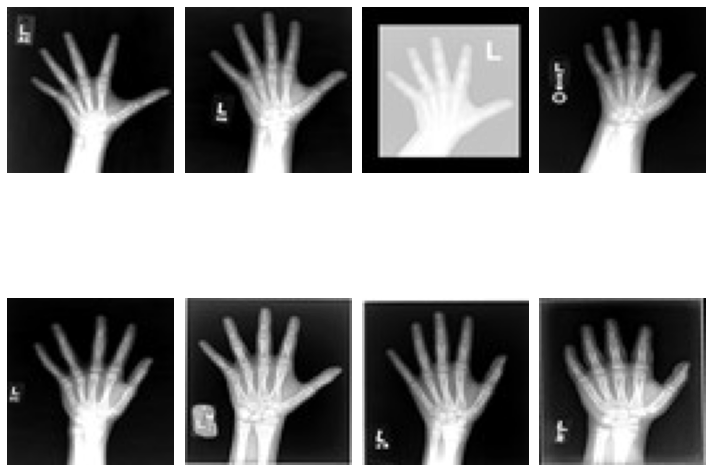

In [8]:
# scan_type could be  AbdomenCT  BreastMRI  CXR  ChestCT  Hand  HeadCT
# Define el escaneo que se va a procesar
# Crea una ruta a la carpeta específica dentro del directorio data_dir
scan_type = "Hand"
im_dir = os.path.join(data_dir, scan_type)
all_filenames = [os.path.join(im_dir, filename) for filename in os.listdir(im_dir)]
random.shuffle(all_filenames)

# Visualise a few of them
# Selecciona aleatoriamente 8 rutas de imágenes de la lista
rand_images = np.random.choice(all_filenames, 8, replace=False)
plot_ims(rand_images, shape=(2, 4))

In [ ]:
# Split into training and testing
# Define la fracción de imágenes que se destinará al conjunto de pruebas 20%
test_frac = 0.2
num_test = int(len(all_filenames) * test_frac)
num_train = len(all_filenames) - num_test
train_datadict = [{"im": fname} for fname in all_filenames[:num_train]]
test_datadict = [{"im": fname} for fname in all_filenames[-num_test:]]
print(f"total number of images: {len(all_filenames)}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 10000
number of images for training: 8000
number of images for testing: 2000


# Create the image transform chain

To train the autoencoder to de-blur/de-noise our images, we'll want to pass the degraded image into the encoder, but in the loss function, we'll do the comparison with the original, undegraded version. In this sense, the loss function will be minimised when the encode and decode steps manage to remove the degradation.

Other than the fact that one version of the image is degraded and the other is not, we want them to be identical, meaning they need to be generated from the same transforms. The easiest way to do this is via dictionary transforms, where at the end, we have a lambda function that will return a dictionary containing the three images – the original, the Gaussian blurred and the noisy (salt and pepper).

In [24]:
# Genera variaciones de la imagen con ruido, crea un nuevo diccionario con la imagen original, la imagen con ruido gaussiano y ruido con sal y pimienta
'''NoiseLambda = Lambda(
    lambda d: {
        "orig": d["im"],
        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),
        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),
    }
 )'''
    
def add_noise(d):
    return {
        "orig": d["im"],
        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),
        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),
    }

# Aplica una serie de transformaciones para procesar y aplicar aumentos de datos a las imágenes de entrenamiento
train_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureTypeD(keys=["im"]),
        Lambda(add_noise),
    ]
)

# Conjunto más limitado de transformaciones aplicadas a las imágnes de prueba
test_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
        Lambda(add_noise),
    ]
)

### Create dataset and dataloader

Hold data and present batches during training.

In [25]:
# Define el tamaño del lote, cantidad de imágenes que se procesarán en cada iteración
# Define el número de hilos de trabajo utilizados para cargar los datos en paralelo
# Crea datasets y dataloaders para los conjuntos de entrenamiento y prueba
batch_size = 300
num_workers = 10

train_ds = CacheDataset(train_datadict, train_transforms, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = CacheDataset(test_datadict, test_transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Loading dataset:   0%|          | 0/8000 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 8000/8000 [00:15<00:00, 506.71it/s]
c:\Course\Lucia\anaconda3\envs\pytorchenv\lib\site-packages\torch\utils\data\dataloader.py:478: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 2000/2000 [00:08<00:00, 248.83it/s]


In [26]:
# Obtiene una única imagen del conjunto de datos y sus versiones degradadas
# Get image original and its degraded versions
def get_single_im(ds):
    loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0, shuffle=True)
    itera = iter(loader)
    return next(itera)

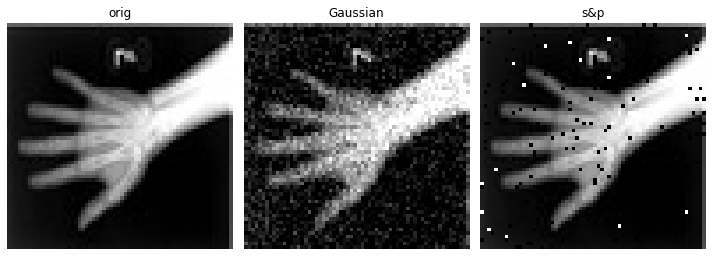

In [27]:
data = get_single_im(train_ds)
plot_ims([data["orig"], data["gaus"], data["s&p"]], titles=["orig", "Gaussian", "s&p"])

In [28]:
def train(dict_key_for_training, max_epochs=10, learning_rate=1e-3):
    model = AutoEncoder(
        spatial_dims=2, # El modelo trabaja con imágenes 2D
        in_channels=1, # La entrada tiene un solo canal (por ej, imágenes en escala de grises)
        out_channels=1, # La salida tiene un solo canal
        channels=(4, 8, 16, 32), # Define el número de canales en las diferentes capas del modelo
        strides=(2, 2, 2, 2), # Define los pasos para las convoluciones, reduciendo la resolución de la imagen en cada capa
    ).to(device)
 
    # Create loss fn and optimiser
    loss_function = torch.nn.MSELoss() # Definir la loss como el MSE
    optimizer = torch.optim.Adam(model.parameters(), learning_rate) # Optimizador Adam para actualizar los parámetros del modelo durante el entrenamiento

    epoch_loss_values = [] # Lista para almacenar la pérdida promedio por época

    t = trange(max_epochs, desc=f"{dict_key_for_training} -- epoch 0, avg loss: inf", leave=True)
    for epoch in t:
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data[dict_key_for_training].to(device)
            optimizer.zero_grad() # Borra los gradientes acumulados de la iteración anterior
            outputs = model(inputs) # Realiza la predicción usando el modelo
            loss = loss_function(outputs, batch_data["orig"].to(device))
            loss.backward() # Calcula los gradientes de pérdida respecto a los parámetros del modelo
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= step # Promedio de la pérdida por época
        epoch_loss_values.append(epoch_loss)
        t.set_description(  # noqa: B038
            f"{dict_key_for_training} -- epoch {epoch + 1}" + f", average loss: {epoch_loss:.4f}"
        )
    return model, epoch_loss_values

In [ ]:
max_epochs = 10
training_types = ["orig", "gaus", "s&p"]
models = []
epoch_losses = []
for training_type in training_types:
    model, epoch_loss = train(training_type, max_epochs=max_epochs)
    models.append(model)
    epoch_losses.append(epoch_loss)

orig -- epoch 0, avg loss: inf:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
plt.figure()
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
for y, label in zip(epoch_losses, training_types):
    x = list(range(1, len(y) + 1))
    (line,) = plt.plot(x, y)
    line.set_label(label)
plt.legend()

In [ ]:
data = get_single_im(test_ds)

recons = []
for model, training_type in zip(models, training_types):
    im = data[training_type]
    recon = model(im.to(device)).detach().cpu()
    recons.append(recon)

plot_ims(
    [data["orig"], data["gaus"], data["s&p"]] + recons,
    titles=["orig", "Gaussian", "S&P"] + ["recon w/\n" + x for x in training_types],
    shape=(2, len(training_types)),
)

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)